1. 탐색적 데이터분석 및 시각화
2. Train Test Split 7:3
3. y: customerType(Online, Offline)
4. DecisionTreeClassifier 수행
5. Metric: Accuracy, f1 Score
6. (핵심)Logistic Regression 결과와 비교



In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

## 1.탐색적 데이터분석 및 시각화

In [4]:
df_pd = pd.read_csv('https://raw.githubusercontent.com/rusita-ai/pyData/master/product.csv')

In [5]:
df_pd.info()

# y를 제외하고는 모두 숫자형 (encoding 필요없음)
# 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15009 entries, 0 to 15008
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           15009 non-null  object 
 1   meanPriceEach  15009 non-null  float64
 2   totalOrder     15009 non-null  float64
 3   orderType_1    15009 non-null  float64
 4   orderType_2    15009 non-null  float64
 5   orderType_3    15009 non-null  float64
 6   totalBundle    15009 non-null  float64
 7   bundleType_1   15009 non-null  float64
 8   bundleType_2   15009 non-null  float64
 9   customerType   15009 non-null  object 
 10  FY             15009 non-null  int64  
 11  Country        15009 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 1.4+ MB


In [6]:
df_pd.head()


,Date,meanPriceEach,totalOrder,orderType_1,orderType_2,orderType_3,totalBundle,bundleType_1,bundleType_2,customerType,FY,Country
0,2015-01-04,1.56,58065.35,10049.66,25228.37,3672.89,19114.43,17280.89,1833.54,Online,2015,25
1,2015-01-04,1.10,2578275.12,575245.44,1311502.53,181058.65,510468.50,429166.89,80986.81,Offline,2015,25
2,2015-01-11,1.17,2335986.11,560119.16,1032606.49,191515.19,551745.27,465764.93,85966.27,Offline,2015,25
3,2015-01-11,1.52,65483.08,14570.74,30445.75,3170.11,17296.48,16715.45,581.03,Online,2015,25
4,2015-01-18,1.65,52559.10,11415.28,25306.56,3345.08,12492.18,10971.43,1520.75,Online,2015,25


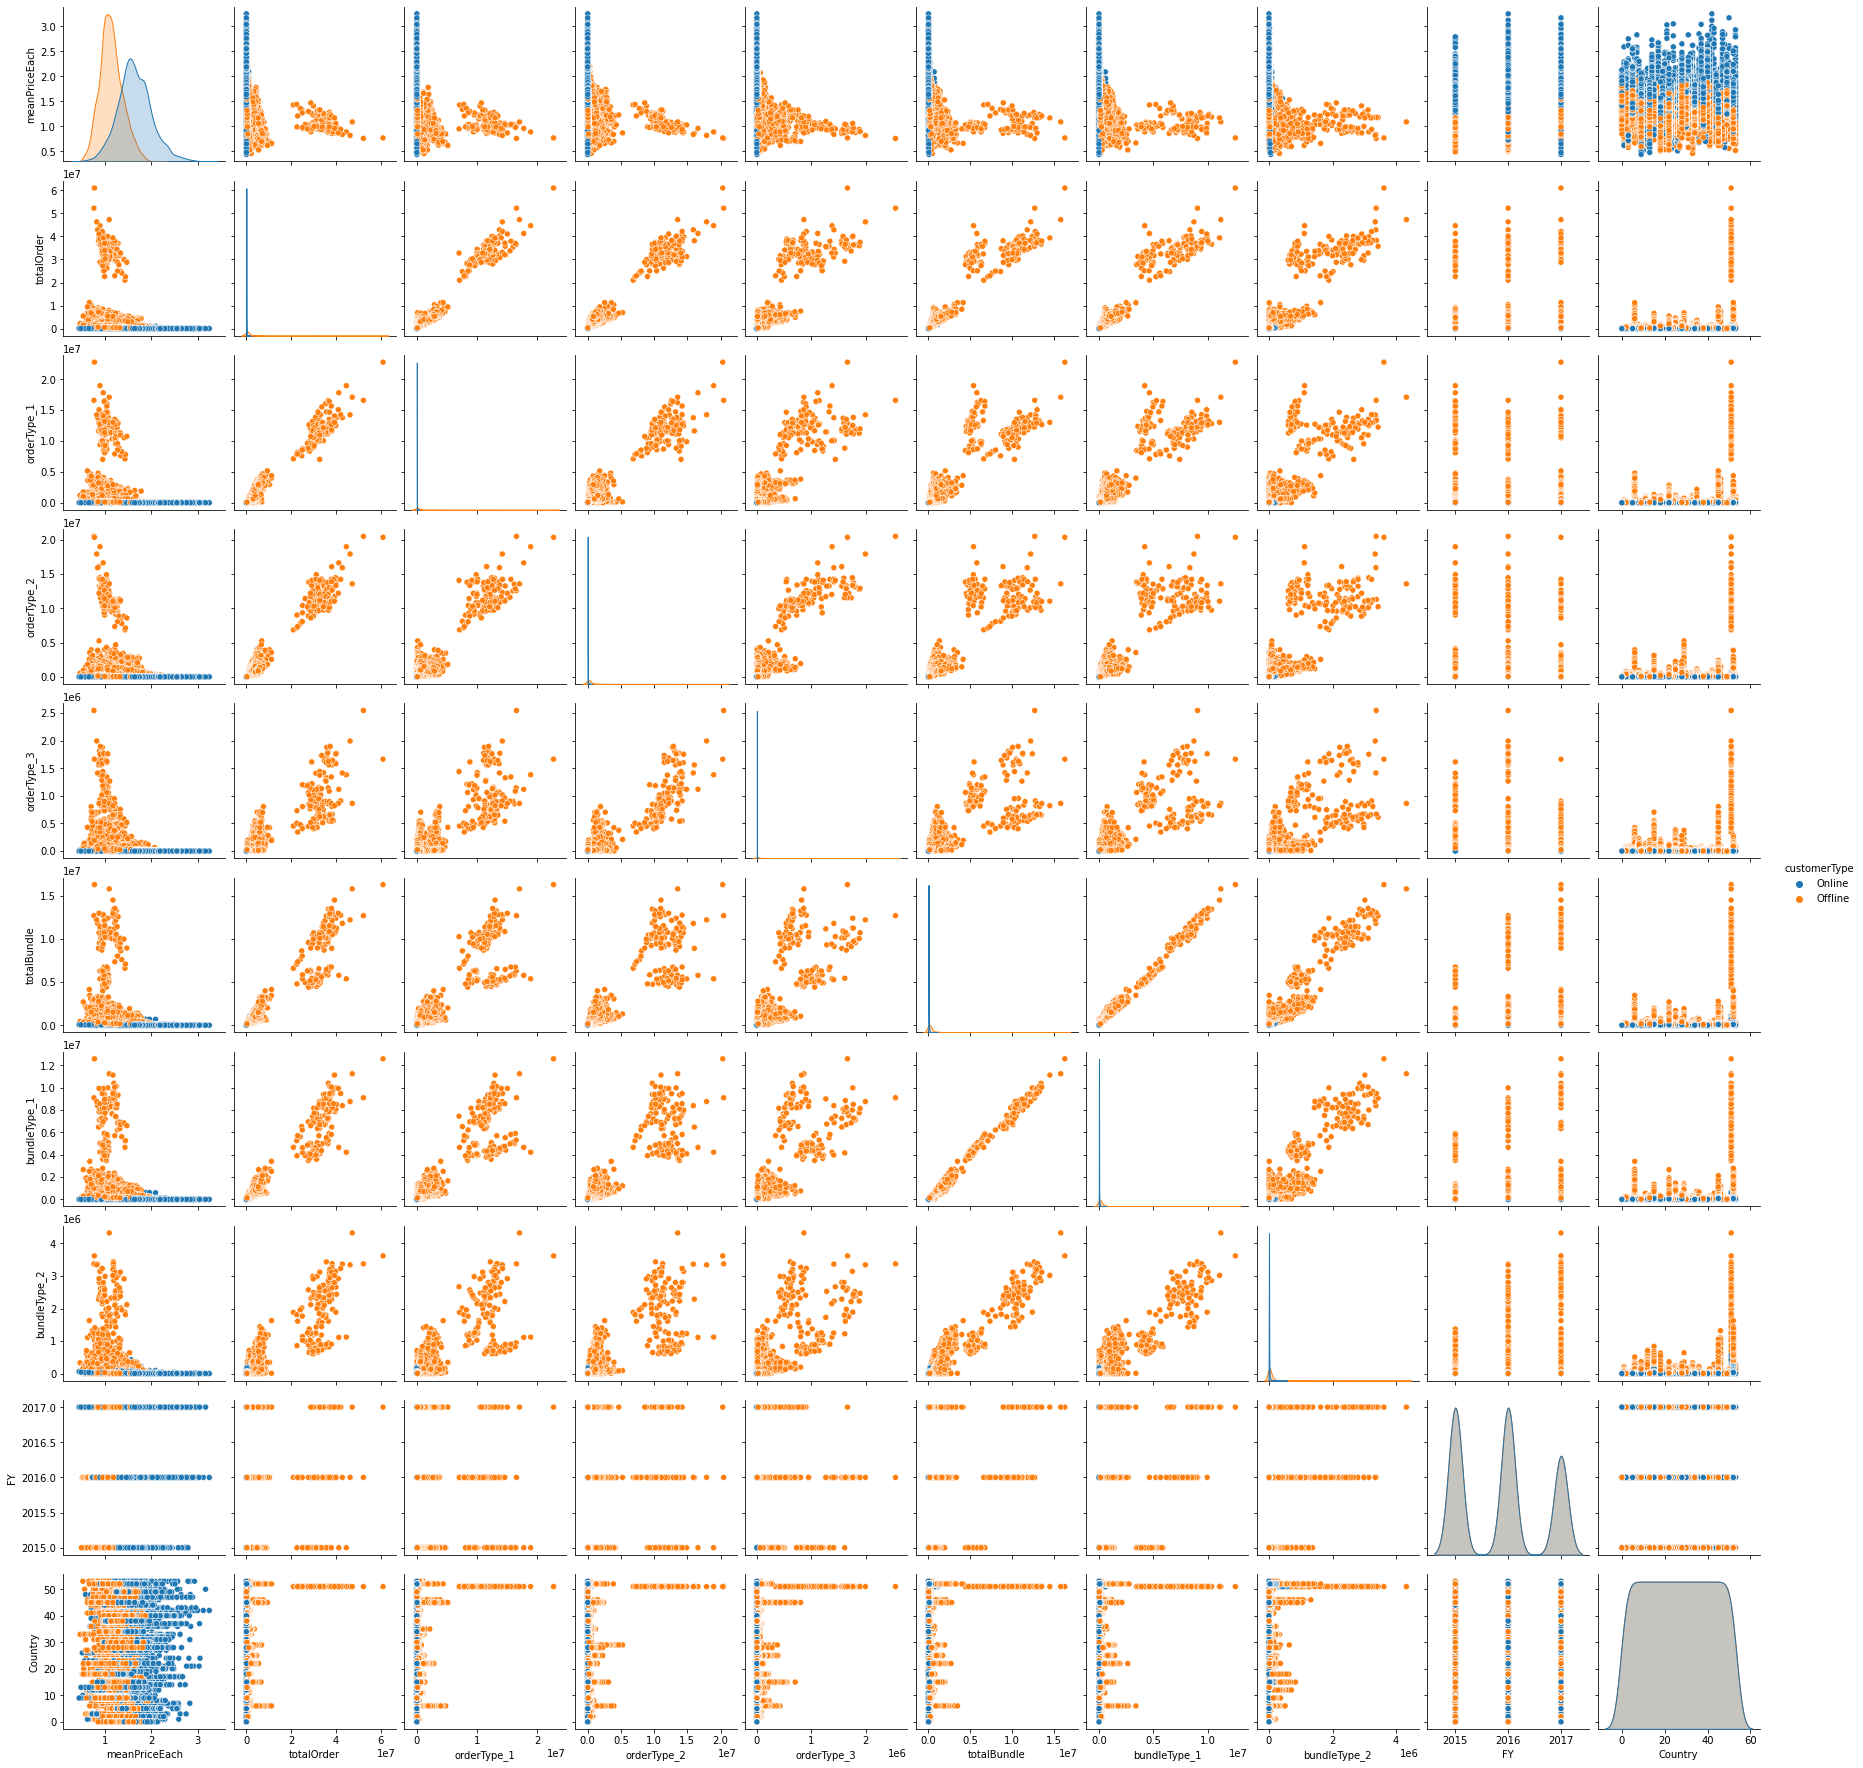

In [7]:
sns.pairplot(hue = 'customerType', 
             data = df_pd)
plt.show()

# totalOrder, totalBundle만 남기자

In [8]:
df_pd['customerType'].value_counts()

Offline    7506
Online     7503
Name: customerType, dtype: int64

In [ ]:
df_pd['Country'].value_counts()

47    278
49    278
27    278
19    278
11    278
3     278
50    278
42    278
34    278
26    278
18    278
10    278
2     278
41    278
39    278
33    278
25    278
17    278
9     278
1     278
48    278
40    278
32    278
24    278
16    278
8     278
35    278
43    278
51    278
4     278
31    278
23    278
15    278
7     278
46    278
38    278
30    278
22    278
14    278
6     278
45    278
37    278
29    278
21    278
13    278
5     278
52    278
44    278
36    278
28    278
20    278
12    278
0     278
53    275
Name: Country, dtype: int64

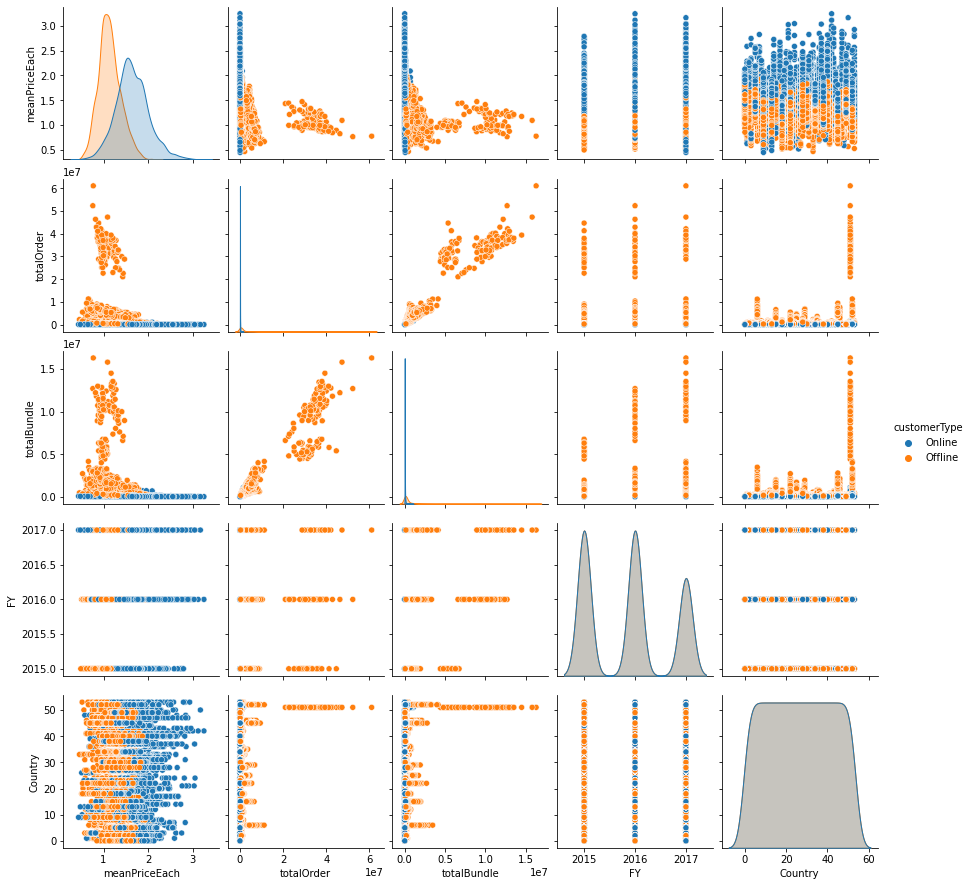

In [9]:
sns.pairplot(hue = 'customerType',
             data = df_pd,
             vars = ['meanPriceEach' , 'totalOrder' , 'totalBundle' , 'FY' , 'Country'])

plt.show()


# total order, total bundle 이 offline이 현저히 높음

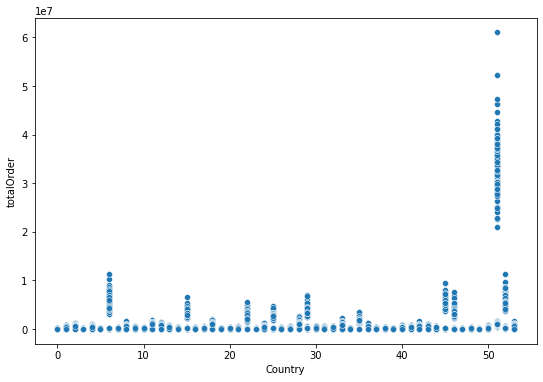

In [ ]:
# country와 totalOrder의 상관관계

plt.figure(figsize=(9, 6))
sns.scatterplot(x = df_pd.Country, y = df_pd.totalOrder)
plt.show()

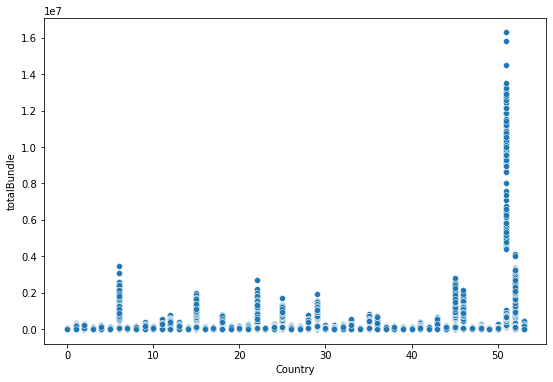

In [ ]:
# country와 totalBundle의 상관관계

plt.figure(figsize=(9, 6))
sns.scatterplot(x = df_pd.Country, y = df_pd.totalBundle)
plt.show()


# country 51에 order가 매우 큼을 알 수 있다

In [10]:
df_pd[df_pd.Country == 51]

,Date,meanPriceEach,totalOrder,orderType_1,orderType_2,orderType_3,totalBundle,bundleType_1,bundleType_2,customerType,FY,Country
1112,2015-01-04,0.95,31324277.73,12357161.34,13624083.05,844093.32,4498940.02,3585321.58,894945.63,Offline,2015,51
1113,2015-01-04,1.46,612910.15,233286.13,216611.20,4370.99,158641.83,115068.71,43573.12,Online,2015,51
1114,2015-01-11,1.42,669528.88,270966.74,260971.60,3830.42,133760.12,106844.49,26915.63,Online,2015,51
1115,2015-01-11,1.01,29063542.75,11544810.53,12134773.38,866574.66,4517384.18,3783261.16,718333.87,Offline,2015,51
1116,2015-01-18,1.42,713120.00,254319.58,311811.01,4020.85,142968.56,101850.23,41118.33,Online,2015,51
...,...,...,...,...,...,...,...,...,...,...,...,...
1385,2017-08-13,1.88,1014709.07,98007.24,230106.14,1414.21,684998.04,612544.62,72449.02,Online,2017,51
1386,2017-08-20,1.41,29913744.37,10507928.78,8837219.28,581074.35,9987521.96,6837126.12,2911554.48,Offline,2017,51
1387,2017-08-20,1.96,1071538.25,108658.66,262747.80,1154.19,698734.90,608822.05,89904.05,Online,2017,51
1388,2017-08-27,2.09,1045992.02,112812.39,250861.84,2119.14,680088.21,588832.95,91249.96,Online,2017,51


In [ ]:
# 분석방향
# 1) 모든 변수를 넣어 모델링(date 제외)
# 2) 불필요해보이는 변수들 빼보기: totalOrder/totalBundle 중 하나만, FY

## 2. Logistic Regression

### 1) Case1: all

In [11]:
df_pd.columns

Index(['Date', 'meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2',
       'customerType', 'FY', 'Country'],
      dtype='object')

In [184]:
X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data: ' , X_train.shape, y_train.shape)
print('Test Data: ' , X_test.shape, y_test.shape)

Train Data:  (10506, 10) (10506,)
Test Data:  (4503, 10) (4503,)


In [185]:
LR_1 = LogisticRegression()
LR_1.fit(X_train, y_train)

y_hat_1 = LR_1.predict(X_test)

In [197]:
accuracy_lr1 = LR_1.score(X_test, y_test)

print('Train Accuracy: ' , LR_1.score(X_train, y_train))
print('Test Accuracy: ' , LR_1.score(X_test, y_test))
print('F1 Score for Online : ' , f1_score(y_test, y_hat_1, pos_label = 'Online'))
print('F1 Score for Offline : ' , f1_score(y_test, y_hat_1, pos_label = 'Offline'))

Train Accuracy:  0.9320388349514563
Test Accuracy:  0.9316011547856984
F1 Score for Online :  0.9350210970464136
F1 Score for Offline :  0.9278012189404594


### 2) Case2: FY 제외, totalOrder 제외

In [199]:
X = df_pd[['meanPriceEach', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

LR_2 = LogisticRegression()
LR_2.fit(X_train, y_train)

y_hat_2 = LR_2.predict(X_test)

In [200]:
accuracy_lr2 = LR_2.score(X_test, y_test)

print('Train Accuracy: ' , LR_2.score(X_train, y_train))
print('Test Accuracy: ' , LR_2.score(X_test, y_test))
print('F1 Score for Online : ' , f1_score(y_test, y_hat_2, pos_label = 'Online'))
print('F1 Score for Offline : ' , f1_score(y_test, y_hat_2, pos_label = 'Offline'))

Train Accuracy:  0.9382257757471921
Test Accuracy:  0.9329335998223407
F1 Score for Online :  0.9346320346320346
F1 Score for Offline :  0.9311445508435932


### 3) Case3 : totalBundle 제외

In [201]:
X = df_pd[['meanPriceEach', 'totalOrder' , 'orderType_1', 'orderType_2',
       'orderType_3', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

LR_3 = LogisticRegression()
LR_3.fit(X_train, y_train)

y_hat_3 = LR_3.predict(X_test)

In [202]:
accuracy_lr3 = LR_3.score(X_test, y_test)

print('Train Accuracy: ' , LR_3.score(X_train, y_train))
print('Test Accuracy: ' , LR_3.score(X_test, y_test))
print('F1 Score for Online : ' , f1_score(y_test, y_hat_3, pos_label = 'Online'))
print('F1 Score for Offline : ' , f1_score(y_test, y_hat_3, pos_label = 'Offline'))

Train Accuracy:  0.9303255282695603
Test Accuracy:  0.9207195203197868
F1 Score for Online :  0.9230769230769232
F1 Score for Offline :  0.9182130584192439


In [ ]:
# total order, FY 제외

## 3. DecisionTreeClassifier
- 전체를 넣고 모델링
- feature importances 체크
- 필요없는 feature 제거 후 다시 모델링
- pruning

In [192]:
# 전체로 모델링

X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data: ' , X_train.shape, y_train.shape)
print('Test Data: ' , X_test.shape, y_test.shape)

Train Data:  (10506, 10) (10506,)
Test Data:  (4503, 10) (4503,)


In [193]:
DT_1 = DecisionTreeClassifier(random_state = 2045)
DT_1.fit(X_train, y_train)
y_hat_dt1 = DT_1.predict(X_test)

In [ ]:
graphviz.Source(export_graphviz(DT_1,
                                class_names = ['Online' , 'Offline'],
                                filled = True))

# 웅장함

In [194]:
print('Train Accuracy: ' , DT_1.score(X_train, y_train))
print('Test Accuracy: ' , DT_1.score(X_test, y_test))
print('F1 Score for Online : ' , f1_score(y_test, y_hat_dt1, pos_label = 'Online'))
print('F1 Score for Offline : ' , f1_score(y_test, y_hat_dt1, pos_label = 'Offline'))

# overfitting되었음을 확인할 수 있다

Train Accuracy:  1.0
Test Accuracy:  0.9882300688429936
F1 Score for Online :  0.9883182719858938
F1 Score for Offline :  0.9881405236070709


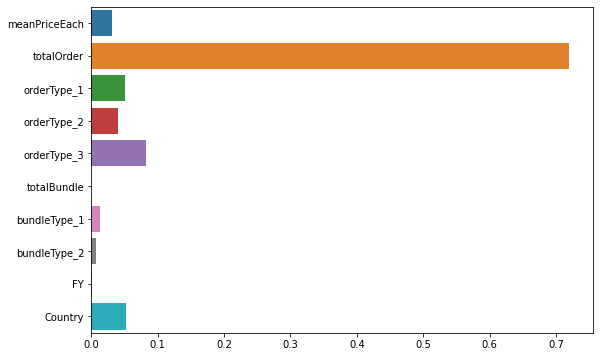

In [122]:
# feature importances 확인 - totalBundle, FY 기여도 없음

plt.figure(figsize = (9, 6))
sns.barplot(DT_1.feature_importances_,
            ['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country'])
plt.show()

- totalBundle, FY를 빼고 모델링

In [126]:
X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

In [127]:
DT_2 = DecisionTreeClassifier(random_state = 2045)
DT_2.fit(X_train, y_train)
y_hat_dt2 = DT_2.predict(X_test)

In [128]:
print('Train Accuracy: ' , DT_2.score(X_train, y_train))
print('Test Accuracy: ' , DT_2.score(X_test, y_test))
print('F1 Score for Online : ' , f1_score(y_test, y_hat_dt2, pos_label = 'Online'))
print('F1 Score for Offline : ' , f1_score(y_test, y_hat_dt2, pos_label = 'Offline'))

# 정확도가 떨어진 것으로 보인다

Train Accuracy:  1.0
Test Accuracy:  0.9864534754608039
F1 Score for Online :  0.9865549922856512
F1 Score for Offline :  0.9863504139628552


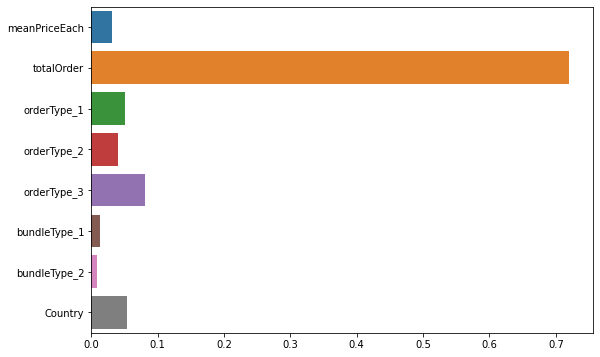

In [129]:
# 기여도 재확인
plt.figure(figsize = (9, 6))
sns.barplot(DT_2.feature_importances_,
            ['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'bundleType_1', 'bundleType_2', 'Country'])
plt.show()

In [203]:
# DT_1 pruning

X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

DT_1 = DecisionTreeClassifier(max_depth = 6,
                              random_state = 2045)
DT_1.fit(X_train, y_train)
y_hat_dt1 = DT_1.predict(X_test)

In [204]:
accuracy_dt1 = DT_1.score(X_test, y_test)

print('Train Accuracy: ' , DT_1.score(X_train, y_train))
print('Test Accuracy: ' , DT_1.score(X_test, y_test))
print('F1 Score for Online : ' , f1_score(y_test, y_hat_dt1, pos_label = 'Online'))
print('F1 Score for Offline : ' , f1_score(y_test, y_hat_dt1, pos_label = 'Offline'))

Train Accuracy:  0.9903864458404721
Test Accuracy:  0.9831223628691983
F1 Score for Online :  0.9831858407079647
F1 Score for Offline :  0.983058403923317


In [205]:
# DT_2 pruning

X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

DT_2 = DecisionTreeClassifier(max_depth = 6,
                              min_samples_split = 9 ,
                              random_state = 2045)
DT_2.fit(X_train, y_train)
y_hat_dt2 = DT_2.predict(X_test)

In [206]:
accuracy_dt2 = DT_2.score(X_test, y_test)

print('Train Accuracy: ' , DT_2.score(X_train, y_train))
print('Test Accuracy: ' , DT_2.score(X_test, y_test))
print('F1 Score for Online : ' , f1_score(y_test, y_hat_dt2, pos_label = 'Online'))
print('F1 Score for Offline : ' , f1_score(y_test, y_hat_dt2, pos_label = 'Offline'))

# pruning 후 DT_1보다 정확도가 올라갔음을 볼 수 있다!

Train Accuracy:  0.9902912621359223
Test Accuracy:  0.9837885853875195
F1 Score for Online :  0.9838459836246957
F1 Score for Offline :  0.9837307778025406


In [207]:
print(accuracy_lr1, accuracy_lr2, accuracy_lr3, accuracy_dt1, accuracy_dt2)

0.9316011547856984 0.9329335998223407 0.9207195203197868 0.9831223628691983 0.9837885853875195
